# Ablation of non-EAP circuits

**Background:** A "TinySQL" model takes as input 1) An Instruction, which is an english data request sentence and 2) A Context, which is a SQL table create statement. The model outputs a Response, which is a SQL select statement.  

**Notebook purpose:** Do mean or zero ablation on the circuits of the models that were not selected through EAP.

**Notebook details:** This notebook:
- Was developed on Google Colab using an A100
- Runs with M1 (TinyStories) with base/CS1/CS2/CS3 models.
- Requires a GITHUB_TOKEN secret to access Martian TinySQL code repository.
- Requires a HF_TOKEN secret to access Martian HuggingFace repository.
- Was developed under a grant provided by withmartian.com ( https://withmartian.com )
- Relies on the nnsight library. Also refer the https://nnsight.net/notebooks/tutorials/activation_patching/ tutorial
- Relies on the https://github.com/PhilipQuirke/quanta_mech_interp library for graphing useful nodes.


# Import libraries
Imports standard libraries. Do not read.

In [1]:
# https://nnsight.net/
# Access 0.4 prerelease version (as at Dec 2024)
#!pip install nnsight==0.4.0.dev0
!pip install -U nnsight -q

In [2]:
!pip install pandas plotly -q

In [1]:
from IPython.display import clear_output
import einops
import torch
import plotly.express as px
import plotly.io as pio
# pio.renderers.default = "colab"

import nnsight
from nnsight import LanguageModel, util

In [2]:
from getpass import getpass
# from google.colab import userdata
import gc
import weakref

In [3]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import json
import datetime

In [4]:
!pip install datasets -q

In [5]:
github_token = 'g'

!pip install --upgrade git+https://{github_token}@github.com/withmartian/TinySQL.git

import TinySQL as qts

  Cloning https://****@github.com/withmartian/TinySQL.git to /tmp/pip-req-build-30z47oc2
  Running command git clone --filter=blob:none --quiet 'https://****@github.com/withmartian/TinySQL.git' /tmp/pip-req-build-30z47oc2
  Resolved https://****@github.com/withmartian/TinySQL.git to commit d2c25f7f1d4db0f3eaca7bdcc136aea3e737a707
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [6]:
clean_tokens = []
patching_results = []

In [7]:
# Key global "input" variables
clean_prompt = ""
corrupt_prompt = ""
clean_tokenizer_index = qts.UNKNOWN_VALUE # Tokenizer vocab index for clean word
corrupt_tokenizer_index = qts.UNKNOWN_VALUE # Tokenizer vocab index for corrupted word
answer_token_index = qts.UNKNOWN_VALUE # Token index in sql command answer of clean/corrupt word

# Key global "results" variables
clean_logit_diff = qts.UNKNOWN_VALUE
corrupt_logit_diff = qts.UNKNOWN_VALUE

# Select model, command set and feature to investigate


In [8]:
model_num = 1                     # 0=GPT2, 1=TinyStories, 2=Qwen, 3=Llama, 4=Granite, 5=SmolLM
cs_num = 1                        # 0=BaseModel, 1=CS1, 2=CS2 or 3=CS3
feature_name = qts.ENGTABLENAME   # ENGTABLENAME, ENGFIELDNAME, DEFTABLESTART, DEFTABLENAME, DEFFIELDNAME, DEFFIELDSEPARATOR
use_novel_names = False           # If True, we corrupt using words not found in the clean prompt or create sql e.g. "little" or "hammer"
use_synonyms_table = False
use_synonyms_field = False
batch_size = 50

# Load model

In [9]:
hf_token = 'hf_

model = qts.load_tinysql_model(model_num, cs_num, auth_token=hf_token, synonym=True)
model_hf = qts.sql_interp_model_location(model_num, cs_num)
clear_output()
print(model)

GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50258, 1024)
    (wpe): Embedding(2048, 1024)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-1): 2 x GPTNeoBlock(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
            (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=False)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=False)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=1024, out_features=4096, bias=True)
          (c_proj): L

In [10]:
N_LAYERS, N_HEADS, D_MODEL, D_HEAD = qts.get_model_sizes(model_num, model)

N_LAYERS=2 N_HEADS=16 D_MODEL=1024 D_HEAD=64


# Generate clean and corrupt data

In [11]:
model.pad_token_id = model.tokenizer.pad_token_id

In [27]:
generator = qts.CorruptFeatureTestGenerator(model_num, cs_num, model.tokenizer, use_novel_names=use_novel_names, use_synonyms_field=use_synonyms_field, use_synonyms_table=use_synonyms_table )
examples = generator.generate_feature_examples(feature_name, batch_size)

# Each examples is corrupted at prompt_token_index. A resulting impact is expected at answer_token_index
prompts = []
ref_answers = []
for example in examples:
    clean_tokenizer_index = example.clean_tokenizer_index
    corrupt_tokenizer_index = example.corrupt_tokenizer_index
    answer_token_index = example.answer_token_index
    
    # Truncate the clean_prompt at answer_token_index
    clean_prompt = example.clean_BatchItem.get_alpaca_prompt() + example.clean_BatchItem.sql_statement
    clean_tokens = model.tokenizer(clean_prompt)["input_ids"]
    clean_tokens = clean_tokens[:answer_token_index+1]
    clean_prompt = model.tokenizer.decode(clean_tokens)

    prompts.append(clean_prompt.split('Response: ')[0] + 'Response: ')
    ref_answers.append(clean_prompt.split('Response: ')[1])

In [25]:
batch_size_mean = 200

generator = qts.CorruptFeatureTestGenerator(model_num, cs_num, model.tokenizer, use_novel_names=use_novel_names, use_synonyms_field=use_synonyms_field, use_synonyms_table=use_synonyms_table )
examples = generator.generate_feature_examples(feature_name, batch_size_mean)

# Each examples is corrupted at prompt_token_index. A resulting impact is expected at answer_token_index
prompts_mean = []
ref_answers_mean = []
for example in examples:
    clean_tokenizer_index = example.clean_tokenizer_index
    corrupt_tokenizer_index = example.corrupt_tokenizer_index
    answer_token_index = example.answer_token_index
    
    # Truncate the clean_prompt at answer_token_index
    clean_prompt = example.clean_BatchItem.get_alpaca_prompt() + example.clean_BatchItem.sql_statement
    clean_tokens = model.tokenizer(clean_prompt)["input_ids"]
    clean_tokens = clean_tokens[:answer_token_index+1]
    clean_prompt = model.tokenizer.decode(clean_tokens)

    prompts_mean.append(clean_prompt.split('Response: ')[0] + 'Response: ')
    ref_answers_mean.append(clean_prompt.split('Response: ')[1])

# Selective ablations whole model

In [14]:
def calculate_similarity(text1, text2):
   def extract_sql_parts(text):
       select_part = text[text.find("SELECT") + 7:text.find("FROM")].strip()
       from_part = text[text.find("FROM") + 5:].strip()
       columns = [c.strip() for c in select_part.split(',')]
       return columns, from_part
   cols1, from1 = extract_sql_parts(text1)
   cols2, from2 = extract_sql_parts(text2)
    
   score = 0
   if "SELECT" in text1 and "SELECT" in text2: score += 0.2
   if "FROM" in text1 and "FROM" in text2: score += 0.2
   if from1 == from2: score += 0.2
   if cols1[0] == cols2[0]: score += 0.2
   if len(cols1) >= 2 and len(cols2) >= 2:
       if cols1[1] == cols2[1]: score += 0.2 
   return score

In [15]:
def compute_head_means(model, prompt_text):
    layer_means = []
    
    with model.generate(prompt_text, max_new_tokens=7) as tracer:
        for layer_idx in range(len(model.transformer.h)):
            layer_output = model.transformer.h[layer_idx].attn.output[0]
            
            output_reshaped = einops.rearrange(
                layer_output, 
                'b s (nh dh) -> b s nh dh',
                nh=N_HEADS
            )
            
            # Calculate mean across batch dimension
            head_means = output_reshaped.mean(dim=0)  # Shape: [s, nh, dh]
            layer_means.append(head_means.save())
            
    return layer_means

def mean_heads_ablation(model, prompt_text, target_layers, heads_per_layer, mean=True):
    N_HEADS = 16
    
    # First compute the means for all layers
    layer_means = compute_head_means(model, prompt_text)
    
    with model.generate(prompt_text, max_new_tokens=7) as tracer:
        hidden_states = []
        for layer_idx in target_layers:
            # Get initial hidden states
            layer_output = model.transformer.h[layer_idx].attn.output[0]
            target_heads = heads_per_layer[layer_idx]
            
            # Reshape for head manipulation
            output_reshaped = einops.rearrange(
                layer_output, 
                'b s (nh dh) -> b s nh dh',
                nh=N_HEADS
            )
            
            head_means = layer_means[layer_idx]  # Shape: [s, nh, dh]
            
            # Replace non-target heads with their means
            for head_idx in range(N_HEADS):
                if head_idx not in target_heads:
                    # Replace with saved means while preserving sequence position
                    if mean:
                        output_reshaped[:, :, head_idx, :] = head_means[:, head_idx, :].unsqueeze(0)
                    else:
                        output_reshaped[:, :, head_idx, :] = torch.zeros_like(head_means[:, head_idx, :].unsqueeze(0))
            
            # Reshape back and modify layer output
            modified_output = einops.rearrange(
                output_reshaped,
                'b s nh dh -> b s (nh dh)', 
                nh=N_HEADS
            )
            model.transformer.h[layer_idx].attn.output = (modified_output,) + model.transformer.h[layer_idx].attn.output[1:]
            
            # Save hidden states for each step
            hidden_states.append(model.transformer.h[layer_idx].output[0].save())

        
        out = model.generator.output.save()
        
    return hidden_states, out

In [24]:
heads_per_layer = {
   0: [11, 3, 1, 8, 15, 14, 13, 7],
   1: [10, 13, 3, 7, 14, 15, 11, 2, 1, 12, 5]
}


In [45]:
target_layers = [0, 1]
# heads_per_layer = {
#    0: [1, 2, 3, 7, 8, 11, 13, 14, 15],
#    1: [13, 3, 7, 14, 15, 11]
# }

heads_per_layer = {
   0: list(range(16)),
   1: list(range(16))
}

results = []
for i, prompt in enumerate(prompts):
   hidden_states, output = mean_heads_ablation(model, prompt, target_layers, heads_per_layer, mean=True)
   gen_text = model.tokenizer.decode(output[0]).split('Response: ')[1]
   similarity = calculate_similarity(gen_text, ref_answers[i])
   results.append({
       'output': gen_text, 
       'similarity': similarity
   })

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

In [46]:
total_similarity = sum(r['similarity'] for r in results)
avg_similarity = total_similarity / len(results)
print(f"Average similarity: {avg_similarity}")

Average similarity: 0.7839999999999999


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Testing Layer 0:

Testing with Layer 0 heads: [1]


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene


Testing with Layer 0 heads: [1, 2]


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene


Testing with Layer 0 heads: [1, 2, 3]


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene


Testing with Layer 0 heads: [1, 2, 3, 7]


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene


Testing with Layer 0 heads: [1, 2, 3, 7, 8]


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene


Testing with Layer 0 heads: [1, 2, 3, 7, 8, 11]


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene


Testing with Layer 0 heads: [1, 2, 3, 7, 8, 11, 13]


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene


Testing with Layer 0 heads: [1, 2, 3, 7, 8, 11, 13, 14]


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene


Testing with Layer 0 heads: [1, 2, 3, 7, 8, 11, 13, 14, 15]


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene


Testing Layer 1:

Testing with Layer 1 heads: [13]


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene


Testing with Layer 1 heads: [13, 3]


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene


Testing with Layer 1 heads: [13, 3, 7]


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene


Testing with Layer 1 heads: [13, 3, 7, 14]


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene


Testing with Layer 1 heads: [13, 3, 7, 14, 15]


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene


Testing with Layer 1 heads: [13, 3, 7, 14, 15, 11]


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

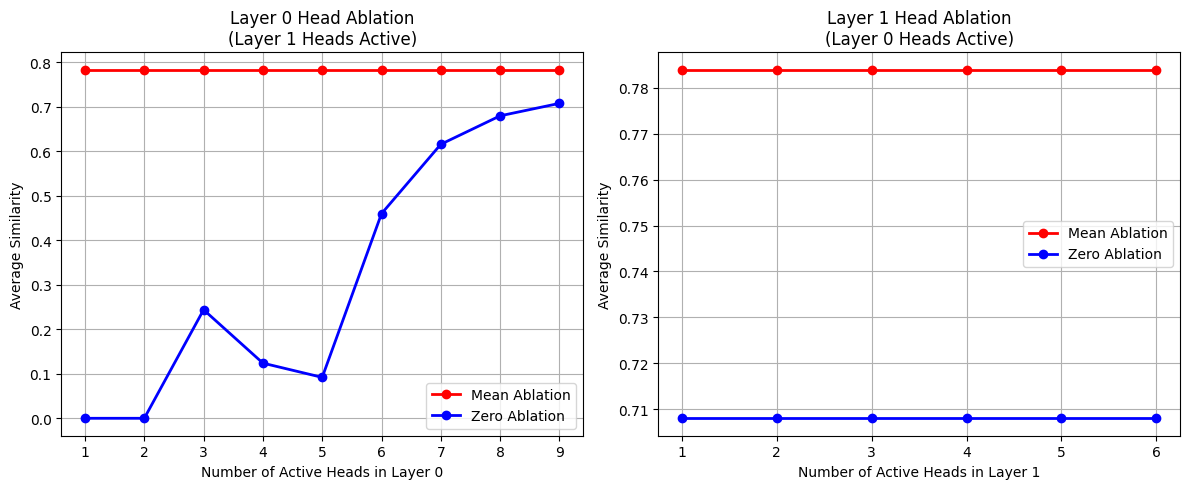


Key Statistics:

Layer 0:
Max similarity with mean ablation: 0.784
Max similarity with zero ablation: 0.708

Layer 1:
Max similarity with mean ablation: 0.784
Max similarity with zero ablation: 0.708


In [34]:
base_heads_per_layer = {
    0: [1, 2, 3, 7, 8, 11, 13, 14, 15],
    1: [13, 3, 7, 14, 15, 11]
}

target_layers = [0, 1]

layer_0_mean_results = []
layer_0_zero_results = []
layer_1_mean_results = []
layer_1_zero_results = []

# Test Layer 0 (keeping Layer 1 intact)
print("\nTesting Layer 0:")
heads_0 = base_heads_per_layer[0]
for num_heads in range(1, len(heads_0) + 1):
    current_heads_0 = heads_0[:num_heads]
    print(f"\nTesting with Layer 0 heads: {current_heads_0}")
    
    # Keep all Layer 1 heads active while testing Layer 0
    current_heads_dict = {
        0: current_heads_0,
        1: base_heads_per_layer[1]  # All heads in layer 1
    }
    
    # Test with mean ablation
    results = []
    for i, prompt in enumerate(prompts):
        hidden_states, output = mean_heads_ablation(model, prompt, target_layers, current_heads_dict, mean=True)
        gen_text = model.tokenizer.decode(output[0]).split('Response: ')[1]
        similarity = calculate_similarity(gen_text, ref_answers[i])
        results.append({
            'output': gen_text,
            'similarity': similarity
        })
    
    avg_similarity = sum(r['similarity'] for r in results) / len(results)
    layer_0_mean_results.append({
        'num_heads': num_heads,
        'heads': current_heads_0,
        'avg_similarity': avg_similarity,
        'detailed_results': results
    })
    
    # Test with zero ablation
    results = []
    for i, prompt in enumerate(prompts):
        hidden_states, output = mean_heads_ablation(model, prompt, target_layers, current_heads_dict, mean=False)
        gen_text = model.tokenizer.decode(output[0]).split('Response: ')[1]
        similarity = calculate_similarity(gen_text, ref_answers[i])
        results.append({
            'output': gen_text,
            'similarity': similarity
        })
    
    avg_similarity = sum(r['similarity'] for r in results) / len(results)
    layer_0_zero_results.append({
        'num_heads': num_heads,
        'heads': current_heads_0,
        'avg_similarity': avg_similarity,
        'detailed_results': results
    })

# Test Layer 1 (keeping Layer 0 intact)
print("\nTesting Layer 1:")
heads_1 = base_heads_per_layer[1]
for num_heads in range(1, len(heads_1) + 1):
    current_heads_1 = heads_1[:num_heads]
    print(f"\nTesting with Layer 1 heads: {current_heads_1}")
    
    # Keep all Layer 0 heads active while testing Layer 1
    current_heads_dict = {
        0: base_heads_per_layer[0],  # All heads in layer 0
        1: current_heads_1
    }
    
    # Test with mean ablation
    results = []
    for i, prompt in enumerate(prompts):
        hidden_states, output = mean_heads_ablation(model, prompt, target_layers, current_heads_dict, mean=True)
        gen_text = model.tokenizer.decode(output[0]).split('Response: ')[1]
        similarity = calculate_similarity(gen_text, ref_answers[i])
        results.append({
            'output': gen_text,
            'similarity': similarity
        })
    
    avg_similarity = sum(r['similarity'] for r in results) / len(results)
    layer_1_mean_results.append({
        'num_heads': num_heads,
        'heads': current_heads_1,
        'avg_similarity': avg_similarity,
        'detailed_results': results
    })
    
    # Test with zero ablation
    results = []
    for i, prompt in enumerate(prompts):
        hidden_states, output = mean_heads_ablation(model, prompt, target_layers, current_heads_dict, mean=False)
        gen_text = model.tokenizer.decode(output[0]).split('Response: ')[1]
        similarity = calculate_similarity(gen_text, ref_answers[i])
        results.append({
            'output': gen_text,
            'similarity': similarity
        })
    
    avg_similarity = sum(r['similarity'] for r in results) / len(results)
    layer_1_zero_results.append({
        'num_heads': num_heads,
        'heads': current_heads_1,
        'avg_similarity': avg_similarity,
        'detailed_results': results
    })

In [38]:
!pip install seaborn -q

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [41]:
import seaborn

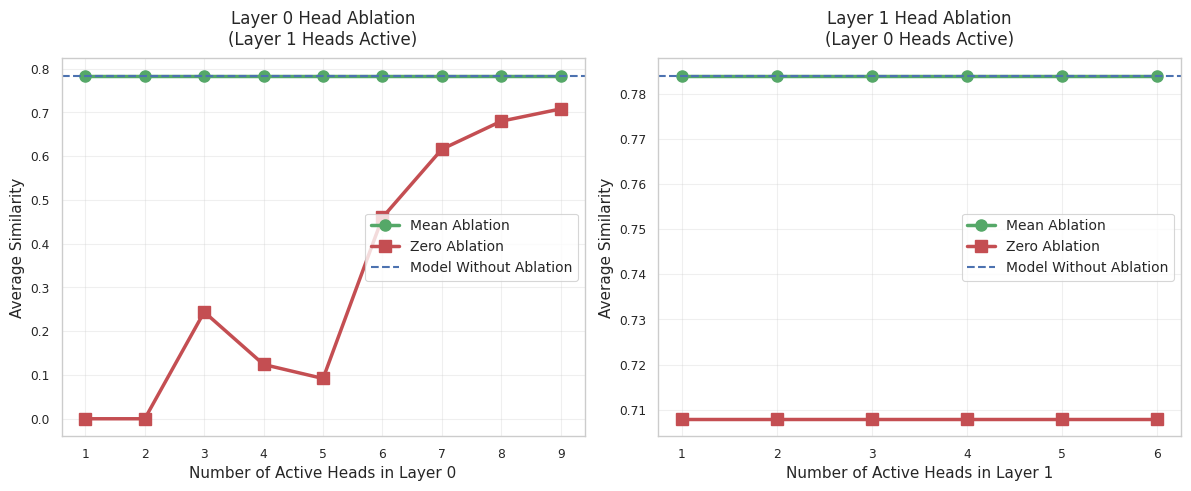

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
sns.set_context("paper")

colors = sns.color_palette("deep")
mean_color = colors[2]  # Deep teal
zero_color = colors[3]  # Deep purple

plt.figure(figsize=(12, 5))

# Plot for Layer 0
plt.subplot(1, 2, 1)
plt.plot([r['num_heads'] for r in layer_0_mean_results], 
         [r['avg_similarity'] for r in layer_0_mean_results], 
         color=mean_color, marker='o', linestyle='-', 
         label='Mean Ablation', linewidth=2.5, markersize=8)
plt.plot([r['num_heads'] for r in layer_0_zero_results], 
         [r['avg_similarity'] for r in layer_0_zero_results], 
         color=zero_color, marker='s', linestyle='-',
         label='Zero Ablation', linewidth=2.5, markersize=8)
plt.axhline(y=0.7839, linestyle='--', linewidth=1.5, label='Model Without Ablation')  # Horizontal line in red

plt.xlabel('Number of Active Heads in Layer 0', fontsize=11)
plt.ylabel('Average Similarity', fontsize=11)
plt.title('Layer 0 Head Ablation\n(Layer 1 Heads Active)', fontsize=12, pad=10)
plt.legend(frameon=True, fontsize=10, loc='center right')  # Changed legend location
plt.grid(True, alpha=0.3)

# Plot for Layer 1
plt.subplot(1, 2, 2)
plt.plot([r['num_heads'] for r in layer_1_mean_results], 
         [r['avg_similarity'] for r in layer_1_mean_results], 
         color=mean_color, marker='o', linestyle='-',
         label='Mean Ablation', linewidth=2.5, markersize=8)
plt.plot([r['num_heads'] for r in layer_1_zero_results], 
         [r['avg_similarity'] for r in layer_1_zero_results], 
         color=zero_color, marker='s', linestyle='-',
         label='Zero Ablation', linewidth=2.5, markersize=8)
plt.axhline(y=0.7839, linestyle='--', linewidth=1.5, label='Model Without Ablation')  # Horizontal line in blue

plt.xlabel('Number of Active Heads in Layer 1', fontsize=11)
plt.ylabel('Average Similarity', fontsize=11)
plt.title('Layer 1 Head Ablation\n(Layer 0 Heads Active)', fontsize=12, pad=10)
plt.legend(frameon=True, fontsize=10, loc='center right')  # Changed legend location
plt.grid(True, alpha=0.3)

plt.tight_layout()

# Save the figure before showing it
fig = plt.gcf()
fig.savefig('ablation_results.pdf', format='pdf', dpi=300, bbox_inches='tight')
fig.savefig('ablation_results.png', dpi=300, bbox_inches='tight')

# Now show the plot
plt.show()


In [77]:
fig.savefig('ablation_results.png', dpi=300, bbox_inches='tight')  # PNG for web/screen


# global ablation

In [71]:
def compute_layer_means_all(model, prompt_texts):
    """Compute means for both attention and MLP outputs across samples."""
    attn_means = []
    mlp_means = []
    with model.generate(prompt_texts, max_new_tokens=7) as tracer:
        for layer_idx in range(N_LAYERS):            
            mlp_output = model.transformer.h[layer_idx].mlp.output
            mlp_mean = mlp_output.mean(dim=0)  # Mean across batch dim
            mlp_means.append(mlp_mean.save())
            
    return attn_means, mlp_means

def mean_ablation_all(model, prompt_text, target_layers, layer_means):
    """Apply mean ablation only to layers NOT in target_layers."""
    attn_means, mlp_means = layer_means
    
    with model.generate(prompt_text, max_new_tokens=7) as tracer:
        hidden_states = []
        for layer_idx in range(N_LAYERS):
            original_mlp = model.transformer.h[layer_idx].mlp.output
            
            if layer_idx not in target_layers:
                mlp_mean = mlp_means[layer_idx]
                
                modified_mlp = mlp_mean.unsqueeze(0).expand_as(original_mlp)
                
                model.transformer.h[layer_idx].mlp.output = modified_mlp
            
            hidden_states.append(model.transformer.h[layer_idx].output[0].save())
            
        out = model.generator.output.save()
        
    return hidden_states, out


In [60]:
def zero_ablation_all(model, prompt_text, target_layers):
    """Apply zero ablation only to layers NOT in target_layers."""
    with model.generate(prompt_text, max_new_tokens=7) as tracer:
        hidden_states = []
        for layer_idx in range(N_LAYERS):
            original_mlp = model.transformer.h[layer_idx].mlp.output
            
            if layer_idx not in target_layers:
                zero_mlp = torch.zeros_like(original_mlp)
                
                model.transformer.h[layer_idx].mlp.output = zero_mlp
            
            hidden_states.append(model.transformer.h[layer_idx].output[0].save())
            
        out = model.generator.output.save()
        
    return hidden_states, out

In [63]:
target_layers = [1]


results = []
for i, prompt in enumerate(prompts):
   hidden_states, output = zero_ablation_all(model, prompt, target_layers)
   gen_text = model.tokenizer.decode(output[0]).split('Response: ')[1]
   similarity = calculate_similarity(gen_text, ref_answers[i])
   results.append({
       'output': gen_text, 
       'similarity': similarity
   })

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

In [64]:
total_similarity = sum(r['similarity'] for r in results)
avg_similarity = total_similarity / len(results)
print(f"Average similarity: {avg_similarity}")

Average similarity: 0.008


In [74]:
layers_all = compute_layer_means_all(model, prompts_mean)

target_layers = [0]


results = []
for i, prompt in enumerate(prompts):
   hidden_states, output = mean_ablation_all(model, prompt, target_layers, layers_all)
   gen_text = model.tokenizer.decode(output[0]).split('Response: ')[1]
   similarity = calculate_similarity(gen_text, ref_answers[i])
   results.append({
       'output': gen_text, 
       'similarity': similarity
   })

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

In [75]:
total_similarity = sum(r['similarity'] for r in results)
avg_similarity = total_similarity / len(results)
print(f"Average similarity: {avg_similarity}")

Average similarity: 0.7839999999999999


# Difference vectors

In [30]:
def compute_batch_means(model, prompts):
    """First compute means across multiple prompts."""
    N_HEADS = 16
    attn_means = []
    mlp_means = []
    
    with model.generate(prompts, max_new_tokens=7) as tracer:
        for layer_idx in range(len(model.transformer.h)):
            # Get attention and MLP outputs
            attn_output = model.transformer.h[layer_idx].attn.output[0]
            mlp_output = model.transformer.h[layer_idx].mlp.output
            
            # For attention, reshape to expose heads
            attn_reshaped = einops.rearrange(
                attn_output, 
                'b s (nh dh) -> b s nh dh',
                nh=N_HEADS
            )
            
            # Compute means across batch dimension
            attn_mean = attn_reshaped.mean(dim=0)  # Shape: [s, nh, dh]
            mlp_mean = mlp_output.mean(dim=0)      # Shape: [s, hidden_dim]
            
            attn_means.append(attn_mean.save())
            mlp_means.append(mlp_mean.save())
    
    return attn_means, mlp_means

def compute_residual_difference(model, prompt_text, attn_means, mlp_means):
    """Run mean ablation and compute difference between final and initial vectors."""
    N_HEADS = 16
    
    with model.generate(prompt_text, max_new_tokens=7) as tracer:
        # Save initial embeddings
        initial_embeddings = model.transformer.wte.output
        
        # Run through transformer with pre-computed means
        for layer_idx in range(len(model.transformer.h)):
            # Replace attention outputs with means
            original_attn = model.transformer.h[layer_idx].attn.output
            attn_mean = attn_means[layer_idx]
            attn_expanded = attn_mean.unsqueeze(0)  # Add batch dim
            modified_attn = einops.rearrange(
                attn_expanded,
                'b s nh dh -> b s (nh dh)', 
                nh=N_HEADS
            )
            model.transformer.h[layer_idx].attn.output = (modified_attn,) + original_attn[1:]
            
            # Replace MLP outputs with means
            mlp_mean = mlp_means[layer_idx]
            mlp_expanded = mlp_mean.unsqueeze(0)  # Add batch dim
            model.transformer.h[layer_idx].mlp.output = mlp_expanded
        
        # Get final vectors after last MLP
        final_vectors = model.transformer.h[-1].mlp.output
        
        # Compute and save difference vectors
        difference_vectors = (final_vectors - initial_embeddings).save()
        
    return difference_vectors

def apply_difference_vectors(model, prompt_text, difference_vectors):
    """Apply saved difference vectors directly to embeddings."""
    with model.generate(prompt_text, max_new_tokens=7) as tracer:
        # Get initial embeddings
        embeddings = model.transformer.wte.output
        
        # Add difference vectors
        modified_embeddings = embeddings + difference_vectors.expand_as(embeddings)
        
        # Apply final layer norm
        normalized = model.transformer.ln_f(modified_embeddings)
        
        # Now pass to language model head
        logits = model.lm_head(normalized)
        
        out = logits.save()
    
    return out

# First compute means across batch of prompts
print("Computing batch means...")
attn_means, mlp_means = compute_batch_means(model, prompts)

# Then compute difference vectors using mean ablation
print("Computing residual difference...")
difference_vectors = compute_residual_difference(model, prompts[0], attn_means, mlp_means)

# Finally, apply to new prompts
print("Testing on prompts...")
results = []
for i, prompt in enumerate(prompts):
    output = apply_difference_vectors(model, prompt, difference_vectors)
    gen_text = model.tokenizer.decode(torch.argmax(output[0], dim=-1))
    similarity = calculate_similarity(gen_text, ref_answers[i])
    results.append({
        'output': gen_text,
        'similarity': similarity
    })

# Print results
for i, result in enumerate(results[:3]):
    print(f"\nPrompt {i}:")
    print(f"Generated: {result['output']}")
    print(f"Similarity: {result['similarity']}")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Computing batch means...
Computing residual difference...
Testing on prompts...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Prompt 0:
Generated:  Instruction: In me is is, is from help api ### ### Context: CREATE TABLE products ( meta V, meta TEXT, ### Response: SELECT
Similarity: 0.2

Prompt 1:
Generated:  Instruction: In me is is, is from help api ### ### Context: CREATE TABLE products ( meta V, meta TEXT, ### Response: SELECT
Similarity: 0.2

Prompt 2:
Generated:  Instruction: In me is is, is from help api ### ### Context: CREATE TABLE products ( meta V, meta TEXT, ### Response: SELECT
Similarity: 0.2
